<a href="https://colab.research.google.com/github/johnmayo93/johnmayo93.github.io/blob/main/240329_DataExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 대구 교통사고 피해 예측

X: 사고일시, 요일, 기상상태, 시군구, 도로형태, 노면상태, 사고유형

Y: ECLO(Equivalent Casualty Loss Only) : 인명피해 심각도
ECLO = 사망자수 * 10 + 중상자수 * 5 + 경상자수 * 3 + 부상자수 * 1

Measurement: RMSLE(Root Mean Squared Logarithmic Error)
부상자: 교통사고로 인하여 5일 미만의 치료를 요하는 부상을 입은 경우

Public Score: 전체 테스트 데이터 중 30%
Private Score: 전체 테스트 데이터 중 70%

데이터 종류 7종류 (+ 제출용)

<학습>
1. 훈련 데이터(39,608) 2019년~2021년
  - X : 사고일시, 요일, 기상상태, 시군구, 도로형태, 노면상태, 사고유형
  - X' : 사고유형-세부분류, 법규위반, 가해운전자 차종/성별/연령/상해정도,피해운전자 차종/성별/연령/상해정도
 - Y : ELCO (사망자수/중상자수/경상자수/부상자수)
                                      
2. 테스트 데이터(10,962) 2022년
  - X : 사고일시, 요일, 기상상태, 시군구, 도로형태, 노면상태, 사고유형
  - Y : 제공하지않음

<외부 데이터>
3. 대한민국 사고 데이터(602,775) : 훈련데이터와 동일<br>
4. 대구 CCTV 정보(1,065) :<br>
무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,소재지지번주소,위도,경도,설치장소,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도
<br>
대구에 존재하는 CCTV 관련 정보 <br>
도로노선방향<br>
01 : 상행<br>
02 : 하행<br>
03 : 양방향<br>
단속구분<br>
01 : 속도<br>
02 : 신호<br>
03 : 통행위반<br>
04 : 불법주정차<br>
99 : 기타<br>
단속구간위치구분<br>
01 : 시점<br>
02 : 종점<br>
보호구역구분<br>
01 : 노인보호구역<br>
02 : 어린이보호구역<br>
99 : 기타<br>

5. 대구 보안등 정보(71,913) : 훈련 데이터에서 시군구와 CCTV 대수 정도로 Feature 생성이 가능하지 않을까? <br>
: 보안등위치명,설치개수,소재지도로명주소,소재지지번주소, 위도, 경도,설치연도,설치형태
6. 대구 어린이 보호 구역 정보(639) : <br>
: 시설종류, 대상시설명, 소재지도로명주소,소재지지번주소,위도,경도, 관리기관명, 관할경찰서명, CCTV설치여부, CCTV설치대수, 보호구역도로폭, 데이터기준일자

7. 대구 주차장 정보(870) : 교통사고의 주차장 사고 3/10 <br>
: 주차장관리번호,주차장명,주차장구분,주차장유형,소재지도로명주소,소재지지번주소,주차구획수,급지구분,부제시행구분,운영요일,평일운영시작시각,평일운영종료시각,토요일운영시작시각,토요일운영종료시각,공휴일운영시작시각,공휴일운영종료시각,요금정보,주차기본시간,주차기본요금,추가단위시간,추가단위요금,1일주차권요금적용시간,1일주차권요금,월정기권요금,결제방법,특기사항,위도,경도,데이터기준일자

In [1]:
# ## Mount GoogleDrive
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
## Library Import
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
## Open Directory
str_Path = '/content/drive/MyDrive/timeguru/car-accident/open'
lstFileList = os.listdir(str_Path)
print(lstFileList)

['sample_submission.csv', 'train.csv', 'test.csv', 'external_open']


In [10]:
df_train = pd.read_csv(os.path.join(str_Path,'train.csv'))
df_test = pd.read_csv(os.path.join(str_Path,'test.csv'))

In [6]:
## 외부데이터
print(os.listdir(os.path.join(str_Path,'external_open')))

df_train_all = pd.read_csv(os.path.join(str_Path,'external_open/countrywide_accident.csv'))
df_CCTV = pd.read_csv(os.path.join(str_Path,'external_open/대구 CCTV 정보.csv'), encoding = 'cp949')
df_security = pd.read_csv(os.path.join(str_Path,'external_open/대구 보안등 정보.csv'), encoding = 'cp949', nrows= 100)
df_child = pd.read_csv(os.path.join(str_Path,'external_open/대구 어린이 보호 구역 정보.csv'), encoding = 'cp949')
df_parking = pd.read_csv(os.path.join(str_Path,'external_open/대구 주차장 정보.csv'), encoding = 'cp949')

['대구 CCTV 정보.csv', '대구 보안등 정보.csv', '대구 어린이 보호 구역 정보.csv', '대구 주차장 정보.csv', 'countrywide_accident.csv']


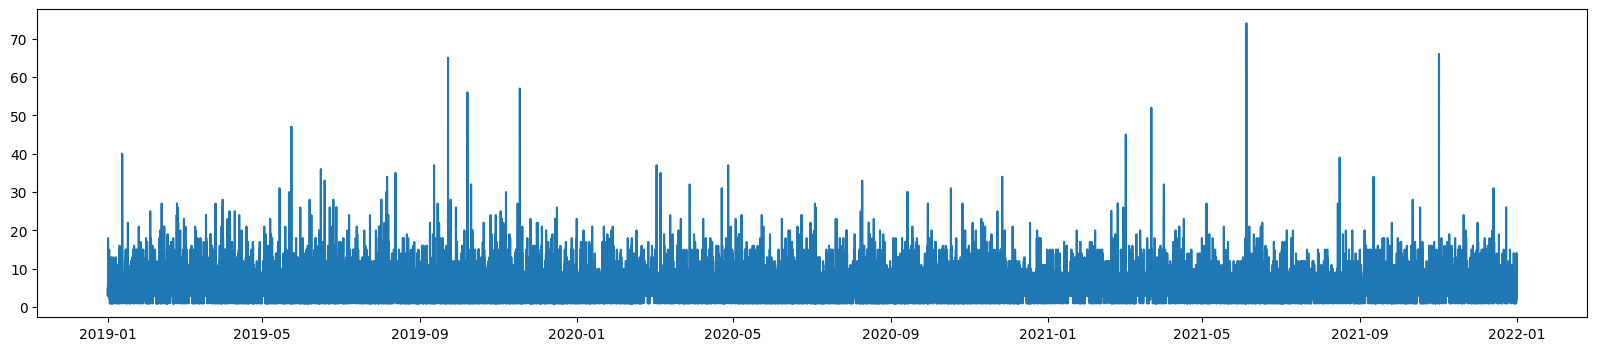

In [13]:
df_train['사고일시'] = pd.to_datetime(df_train['사고일시'], format ="%Y-%m-%d %H")
fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(111)
ax1.plot(df_train['사고일시'],df_train['ECLO'])

In [7]:
for i in range(len(df_train_all.columns)):
  print(f'Column {i+1} : {df_train_all.columns[i]} \n {df_train_all[df_train_all.columns[i]].unique()}')

Column 1 : ID 
 ['COUNTRYWIDE_ACCIDENT_000000' 'COUNTRYWIDE_ACCIDENT_000001'
 'COUNTRYWIDE_ACCIDENT_000002' ... 'COUNTRYWIDE_ACCIDENT_602772'
 'COUNTRYWIDE_ACCIDENT_602773' 'COUNTRYWIDE_ACCIDENT_602774']
Column 2 : 사고일시 
 ['2019-01-01 00' '2019-01-01 01' '2019-01-01 02' ... '2021-12-31 21'
 '2021-12-31 22' '2021-12-31 23']
Column 3 : 요일 
 ['화요일' '수요일' '목요일' '금요일' '토요일' '일요일' '월요일']
Column 4 : 기상상태 
 ['맑음' '흐림' '눈' '기타' '비' '안개']
Column 5 : 시군구 
 ['서울특별시 강서구 방화동' '경기도 포천시 소흘읍' '경기도 양주시 고암동' ... '경상북도 문경시 창동'
 '전라남도 목포시 경동2가' '전라북도 군산시 송풍동']
Column 6 : 도로형태 
 ['교차로 - 교차로횡단보도내' '교차로 - 교차로안' '기타 - 기타' '교차로 - 교차로부근' '단일로 - 기타'
 '단일로 - 터널' '주차장 - 주차장' '단일로 - 고가도로위' '단일로 - 교량' '단일로 - 지하차도(도로)내'
 '미분류 - 미분류' '단일로 - 철길건널목']
Column 7 : 노면상태 
 ['건조' '젖음/습기' '기타' '서리/결빙' '적설' '해빙' '침수' nan]
Column 8 : 사고유형 
 ['차대사람' '차대차' '차량단독' '철길건널목']
Column 9 : 사고유형 - 세부분류 
 ['횡단중' '기타' '측면충돌' '길가장자리구역통행중' '공작물충돌' '추돌' '차도통행중' '정면충돌' '후진중충돌'
 '보도통행중' '전도전복 - 전도' '전도전복 - 전복' '도로외이탈 - 기타' '도로외이탈 - 추락' '주/정차차량 충돌

In [8]:
df_train.iloc[:1].T

,0
ID,ACCIDENT_00000
사고일시,2019-01-01 00
요일,화요일
기상상태,맑음
시군구,대구광역시 중구 대신동
도로형태,단일로 - 기타
노면상태,건조
사고유형,차대사람
사고유형 - 세부분류,길가장자리구역통행중
법규위반,안전운전불이행
